In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "a"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
# Remove features to be dropped from previous notebook
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

30


In [5]:
# one-vs-rest special
posclass_df = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
negclass_df = y_df_FULL[~y_df_FULL["class"].isin(classes_to_keep)].sample(
    n=len(posclass_df)
)

# negclass_df["class"].value_counts()
negclass_df["class"] = f"Not{classes_to_keep[0]}"

y_df = pd.concat([posclass_df, negclass_df]).sample(frac=1)  # Shuffle
X_df = X_df_FULL.loc[y_df.index]
X = X_df.to_numpy()
y = y_df.to_numpy().ravel()

In [6]:
locpath = os.path.join("results", results_subfolder, "random forest")
Path(locpath).mkdir(parents=True, exist_ok=True)

In [7]:
# Make sure we're not over fitting

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, stratify=y, random_state=settings_dict["seed_choice"]
)

rfc = RandomForestClassifier(
    random_state=settings_dict["seed_choice"], max_depth=3, n_jobs=-1
)
# Important to make sure it's not overfitting.
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.9571619812583668
0.9566395663956639


In [8]:
y_pred = cross_val_predict(rfc, X, y, cv=5, n_jobs=-1)

F1 = 94.80 %
Accuracy = 94.80 %
Matthew's Coefficient = 89.61 %


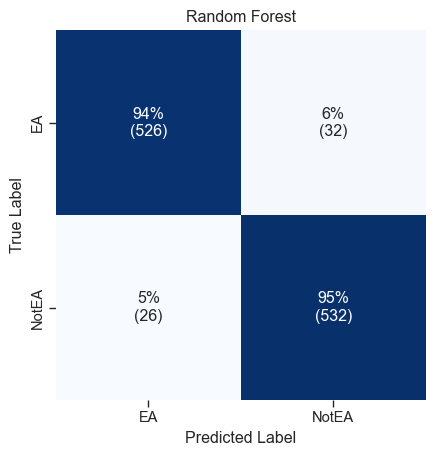

In [9]:
acc_train = accuracy_score(y, y_pred)
f1score_train = f1_score(y, y_pred, average="macro")
matthew_coef_train = matthews_corrcoef(y, y_pred)
print(
    f"F1 = {f1score_train*100:.2f} %\nAccuracy = {acc_train*100:.2f} %\nMatthew's Coefficient = {matthew_coef_train*100:.2f} %"
)

ax = utils.plot_cm(y_true=y, y_pred=y_pred)

plt.title("Random Forest")
# plt.savefig(os.path.join(locpath, "confusion_matrix.pdf"), bbox_inches="tight")
plt.show()

In [10]:
table1 = {
    'EA': 81393,
    'EW': 369707,
    'Mira': 11879,
    'CEP': 1610,
    'RSCVN': 81393,
    'SR': 119261,
    'DSCT': 16709,
    'BYDra': 84697,
    'RRc': 13875,
    'RR': 32518,
}
total = sum(table1.values())
table1_ratio = {key: value / total for key, value in table1.items()}
max_ratio = max(table1_ratio.values())
sample_sizes = {key: int(500*value / max_ratio) for key, value in table1_ratio.items()}
sample_sizes

{'EA': 110,
 'EW': 500,
 'Mira': 16,
 'CEP': 2,
 'RSCVN': 110,
 'SR': 161,
 'DSCT': 22,
 'BYDra': 114,
 'RRc': 18,
 'RR': 43}

In [11]:
sum(sample_sizes.values()) - 110

986

In [12]:
sample_sizes = {'EA': int(110//2.04), 'NotEA': int(986//2.04)}
sample_sizes

{'EA': 53, 'NotEA': 483}

In [13]:
HIDDENX_df = pd.read_csv("data/HIDDENX_df_ovr.csv", index_col=0)
HIDDENX_df = HIDDENX_df.loc[:,X_df.columns]
HIDDENX_df = HIDDENX_df.dropna()


HIDDENy_df = pd.read_csv("data/HIDDENy_df_ovr.csv", index_col=0)
HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]


# RESAMPLE TO BE OF RATIO OF REAL WORLD
HIDDENy_df_resampled = []
for cl, subdf in HIDDENy_df.groupby('class'):
    HIDDENy_df_resampled.append(
        subdf.sample(
            n=sample_sizes[cl], 
            random_state=settings_dict['seed_choice']
        )
    )

HIDDENy_df = pd.concat(HIDDENy_df_resampled).sample(frac=1,random_state=settings_dict['seed_choice'])
HIDDENX_df = HIDDENX_df.loc[HIDDENy_df.index]
HIDDENy_df = HIDDENy_df.loc[HIDDENX_df.index]

In [14]:
HIDDENy_df.value_counts()

class
NotEA    483
EA        53
Name: count, dtype: int64

In [15]:
HIDDENX = HIDDENX_df.to_numpy()
HIDDENy = HIDDENy_df.to_numpy().ravel()

In [16]:
rfc_pred = rfc.predict(HIDDENX)

Random Forest
	Expected Score from training:
		F1 ≈ 94.80 %
	Actual score on hidden set:
		F1 = 89.29 %


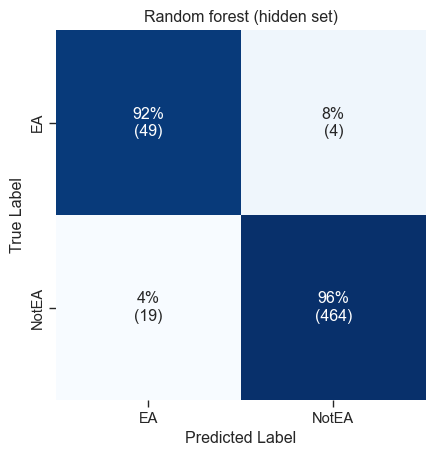

In [17]:
print("Random Forest")
acc = accuracy_score(y_true=HIDDENy, y_pred=rfc_pred)
f1score = f1_score(y_true=HIDDENy, y_pred=rfc_pred, average="macro")
matthew_coef = matthews_corrcoef(y_true=HIDDENy, y_pred=rfc_pred)

print("\tExpected Score from training:")
print(f"\t\tF1 ≈ {100*f1score_train:.2f} %")

print("\tActual score on hidden set:")
# print(f"\tAcc = {100*acc:.2f} %")
print(f"\t\tF1 = {100*f1score:.2f} %")

ax = utils.plot_cm(y_true=HIDDENy, y_pred=rfc_pred)
plt.title(f"Random forest (hidden set)")
plt.savefig(os.path.join(locpath, "hidden_cm.pdf"), bbox_inches="tight")
# plt.savefig(f"hidden_cm/{metric_str}.pdf",bbox_inches = 'tight')
plt.show()

In [18]:
HIDDENy_df.value_counts()

class
NotEA    483
EA        53
Name: count, dtype: int64